# Graph Neural Networks 

In [20]:
import os

import tensorflow as tf
import tensorflow_gnn as tfgnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split



## Overall Process

The general processs we will follow for this project is as follows:

1) Read the Datasets
2) Parse as Tensors
3) Build Pre-process model
4) Build train model
5) Fit train model

In [ ]:
!wget https://www.chrsmrrs.com/graphkerneldatasets/COLLAB.zip 

!tar -xf COLLAB.zip

### Graph Labels 

The COLLAB is a widely used benchmark dataset for graph neural networks. It maps the collaboration networks of researchers, labeling the networks as either 0: High Energy Physics, 1: Condensed Matter Physics, or 2: Astro Physics, depending on which field the researcher belongs to. 

In [21]:
# Read in the data for the edges
edges = pd.read_csv('COLLAB/COLLAB_A.txt', sep=',',header=None)
edges.rename({0:'source',1:'target'}, axis=1, inplace=True)

# Create the data for the nodes by taking the unique nodes from the source and target edges and concatenating them
nodes = pd.concat([pd.DataFrame(edges['source'].unique()), pd.DataFrame(edges['target'].unique())],axis=0)
nodes.rename({0:'node'}, axis=1, inplace=True)
nodes = pd.DataFrame(nodes['node'].unique())
nodes.rename({0:'node'}, axis=1, inplace=True)
nodes.sort_values(by=['node'], inplace = True)

# Read in the graph indicators
graph_groups = pd.read_csv('COLLAB/COLLAB_graph_indicator.txt', header=None)
graph_groups.rename({0:'graph'},axis=1, inplace=True)
# print(graph_groups.head())

# Read in the graph labels 
labels = pd.read_csv('COLLAB/COLLAB_graph_labels.txt',header=None)
labels.rename({0:'label'},axis=1,inplace=True)
labels['graph'] = range(1,5001)

nodes = nodes.join(graph_groups)
nodes = nodes.merge(labels, how='left', on='graph')

print(nodes.head())
print(nodes.tail())




   node  graph  label
0     1      1      1
1     2      1      1
2     3      1      1
3     4      1      1
4     5      1      1
          node  graph  label
372469  372470   5000      3
372470  372471   5000      3
372471  372472   5000      3
372472  372473   5000      3
372473  372474   5000      3


In [29]:
grouped_edges = pd.merge(edges, graph_groups, left_index=True, right_index=True)
grouped_edges.rename({0:'source',1:'target'}, axis=1, inplace=True)

graphs = []

for i in range(5000):
   el = grouped_edges[grouped_edges.graph == i+1]
   G = nx.from_pandas_edgelist(el, source='source',target='target')
   graphs.append(G)


print(graphs[1].edges)


<class 'networkx.classes.reportviews.EdgeView'>


Graph with 28 nodes and 27 edges


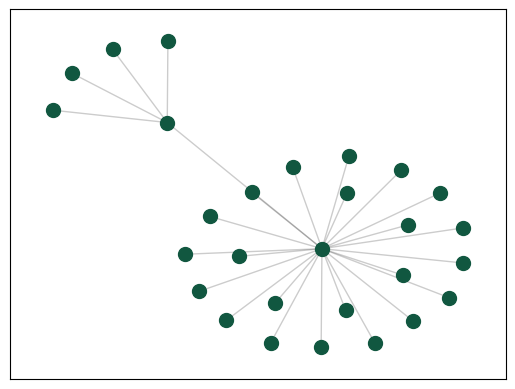

In [26]:
print(graphs[1])

GG=graphs[1]

pos = nx.spring_layout(GG, seed=1987)

nx.draw_networkx_edges(GG, pos, alpha=0.2)
nx.draw_networkx_nodes(GG, pos, nodelist=GG.nodes(),
                       node_color='#115740', node_size=100)

In [8]:
# Split data into test and train sets

node_train, node_test = train_test_split(nodes,test_size=0.15,random_state=42)
edge_train = edges.loc[~((edges['source'].isin(node_test.index)) | (edges['target'].isin(node_test.index)))]
edge_test = edges.loc[(edges['source'].isin(node_test.index)) | (edges['target'].isin(node_test.index))]

In [9]:
# Define a function to create a graph tensor from the nodes and edges inputs

def create_graph_tensor(node_df, edge_df):
   graph_tensor = tfgnn.GraphTensor.from_pieces(
      context = tfgnn.Context.from_fields(
         features={'labels': np.array(labels['label'],dtype='int32').reshape(len(labels),1)}),
      node_sets= {'node': tfgnn.NodeSet.from_fields(
         sizes=[len(nodes)], 
         features={'graph':np.array(nodes['graph'],dtype='int32').reshape(len(nodes),1)})},
      edge_sets= {
         'edge': tfgnn.EdgeSet.from_fields(
               sizes=[len(edges)],
               features={},
               adjacency=tfgnn.Adjacency.from_indices(
                  source=('node', edges['source']),
                  target=('node', edges['target'])))})
   return graph_tensor
   
   # Create graph tensors for the training and validation sets

   

full_tensor = create_graph_tensor(nodes,edges)
train_tensor = create_graph_tensor(node_train,edge_train)

In [ ]:
#Create the graph spec

graph_spec = train_tensor.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [16]:
def node_batch_merge(graph):
    # graph = graph.merge_batch_to_components()
    context_features = graph.context.get_features_dict()
    label = context_features.pop('labels')
    new_graph = graph.replace_features(
        context=context_features)
    return new_graph, label

In [17]:
input_graph, train_label = node_batch_merge(train_tensor)


In [19]:
model_input_graph_spec, label_spec = input_graph, train_label

model = _build_model(model_input_graph_spec)

AttributeError: 'GraphTensor' object has no attribute 'value_type'